In [13]:
import os

face_data_dir = 'kaggleData/dataset1'

if os.path.exists(face_data_dir):
    print(f"Contents of '{face_data_dir}':")
    for item in os.listdir(face_data_dir):
        item_path = os.path.join(face_data_dir, item)
        print(f"- {item}")
else:
    print(f"Error: Directory '{face_data_dir}' not found.")

Contents of 'kaggleData/dataset1':
- .DS_Store
- test
- train
- validation


In [14]:
import os

face_data_dir = 'kaggleData/dataset2'

if os.path.exists(face_data_dir):
    print(f"Contents of '{face_data_dir}':")
    for item in os.listdir(face_data_dir):
        item_path = os.path.join(face_data_dir, item)
        print(f"- {item}")
else:
    print(f"Error: Directory '{face_data_dir}' not found.")

Contents of 'kaggleData/dataset2':
- .DS_Store
- test
- train
- validation


In [ ]:
import os
import random
import shutil

main_dataset_dir = 'kaggleData'
dataset_name = 'dataset1'
dataset1_path = os.path.join(main_dataset_dir, dataset_name)

data_dirs = {'train': 'sampled_train',
             'test': 'sampled_test',
             'validation': 'sampled_val'}  

sampling_ratio = 0.6  # Keep 60% of the original data

for original_subdir, sampled_subdir_name in data_dirs.items():
    original_dir = os.path.join(dataset1_path, original_subdir)
    sampled_dir = os.path.join(dataset1_path, sampled_subdir_name)
    os.makedirs(sampled_dir, exist_ok=True)

    if os.path.exists(original_dir) and os.path.isdir(original_dir):
        for class_name in os.listdir(original_dir):
            original_class_dir = os.path.join(original_dir, class_name)
            sampled_class_dir = os.path.join(sampled_dir, class_name)
            os.makedirs(sampled_class_dir, exist_ok=True)

            if os.path.isdir(original_class_dir):
                image_files = [f for f in os.listdir(original_class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                num_to_sample = int(len(image_files) * sampling_ratio)
                sampled_files = random.sample(image_files, num_to_sample)

                for file_name in sampled_files:
                    original_path = os.path.join(original_class_dir, file_name)
                    sampled_path = os.path.join(sampled_class_dir, file_name)
                    shutil.copy2(original_path, sampled_path)  # Copy with metadata
        print(f"Sampling of '{original_subdir}' complete. Sampled data saved to: {sampled_dir}")
    else:
        print(f"Warning: Directory '{original_dir}' not found.")

print("Sampling process completed for train, test, and validation (if present).")

Sampling of 'train' complete. Sampled data saved to: kaggleData/dataset1/sampled_train
Sampling of 'test' complete. Sampled data saved to: kaggleData/dataset1/sampled_test
Sampling of 'validation' complete. Sampled data saved to: kaggleData/dataset1/sampled_val
Sampling process completed for train, test, and validation (if present).


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

main_dataset_dir = 'kaggleData'
dataset_name = 'dataset1'
dataset1_path = os.path.join(main_dataset_dir, dataset_name)
image_height = 128
image_width = 128
batch_size = 32
epochs = 30
learning_rate = 0.0005
num_classes = 2

sampled_train_dir = os.path.join(dataset1_path, 'sampled_train')
sampled_val_dir = os.path.join(dataset1_path, 'sampled_val')
sampled_test_dir = os.path.join(dataset1_path, 'sampled_test')

train_dataset = tf.keras.utils.image_dataset_from_directory(
    sampled_train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    sampled_val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    sampled_test_dir,
    labels='inferred',
    label_mode='categorical',

Found 29809 files belonging to 2 classes.
Found 8389 files belonging to 2 classes.
Found 3859 files belonging to 3 classes.
Class names: ['fake', 'real']
Number of classes: 2 

Starting training of the tweaked model from scratch...
Epoch 1/30
932/932 [==============================] - 198s 212ms/step - loss: 0.6005 - accuracy: 0.7177 - val_loss: 0.5067 - val_accuracy: 0.7585
Epoch 2/30
932/932 [==============================] - 240s 258ms/step - loss: 0.2869 - accuracy: 0.8771 - val_loss: 0.6148 - val_accuracy: 0.7685
Epoch 3/30
932/932 [==============================] - 237s 254ms/step - loss: 0.1963 - accuracy: 0.9219 - val_loss: 0.3318 - val_accuracy: 0.8529
Epoch 4/30
932/932 [==============================] - 240s 258ms/step - loss: 0.1556 - accuracy: 0.9377 - val_loss: 0.2242 - val_accuracy: 0.9038
Epoch 5/30
932/932 [==============================] - 229s 245ms/step - loss: 0.1382 - accuracy: 0.9436 - val_loss: 0.4375 - val_accuracy: 0.8547
Epoch 6/30
932/932 [==================

KeyboardInterrupt: 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

main_dataset_dir = 'kaggleData'
dataset_name = 'dataset1'
dataset1_path = os.path.join(main_dataset_dir, dataset_name)
image_height = 128
image_width = 128
batch_size = 32
epochs = 30
learning_rate = 0.0005
num_classes = 2
l2_lambda = 0.0001

sampled_train_dir = os.path.join(dataset1_path, 'sampled_train')
sampled_val_dir = os.path.join(dataset1_path, 'sampled_val')
sampled_test_dir = os.path.join(dataset1_path, 'sampled_test')

train_dataset = tf.keras.utils.image_dataset_from_directory(
    sampled_train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    sampled_val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    sampled_test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=False
)

class_names = train_dataset.class_names
print("Class names:", class_names)
print("Number of classes:", num_classes, "\n")

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3),
                  kernel_regularizer=regularizers

Found 29809 files belonging to 2 classes.
Found 8389 files belonging to 2 classes.
Found 3859 files belonging to 3 classes.
Class names: ['fake', 'real']
Number of classes: 2 

Starting training with L2 regularization and early stopping...
Epoch 1/30
932/932 [==============================] - 204s 219ms/step - loss: 0.5851 - accuracy: 0.7477 - val_loss: 0.5811 - val_accuracy: 0.7623
Epoch 2/30
932/932 [==============================] - 207s 222ms/step - loss: 0.3128 - accuracy: 0.8941 - val_loss: 0.4154 - val_accuracy: 0.8385
Epoch 3/30
932/932 [==============================] - 220s 236ms/step - loss: 0.2501 - accuracy: 0.9229 - val_loss: 0.3374 - val_accuracy: 0.8927
Epoch 4/30
932/932 [==============================] - 224s 241ms/step - loss: 0.2212 - accuracy: 0.9370 - val_loss: 0.3326 - val_accuracy: 0.8882
Epoch 5/30
932/932 [==============================] - 226s 243ms/step - loss: 0.2058 - accuracy: 0.9452 - val_loss: 0.3587 - val_accuracy: 0.8750
Epoch 6/30
932/932 [==========

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/sathvikanadipalli/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/64/_h342z8175d41lnx0r7jdg8r0000gn/T/ipykernel_98772/1566807913.py", line 104, in <module>
      loss, accuracy = model.evaluate(test_dataset)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1852, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,2] labels_size=[32,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_164239]

**Pivoting Project Ideas: want to make a chrome extension that allows you to select an image on a screen and determine if it is fake or not**

In [ ]:
import tensorflow as tf
import os

main_dataset_dir = 'Midjourney_Exp2'

image_height = 224
image_width = 224
batch_size = 32

def load_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='binary',
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=True
    )
    return dataset

train_dir = os.path.join(main_dataset_dir, 'train')
valid_dir = os.path.join(main_dataset_dir, 'valid')
test_dir = os.path.join(main_dataset_dir, 'test')

sample_train = load_dataset(train_dir)
sample_valis = load_dataset(valid_dir)
sample_test = load_dataset(test_dir)

print("Sample Training Dataset:")
for image_batch, labels_batch in sample_train.take(1):
    print("Image batch shape:", image_batch.numpy().shape)
    print("Labels batch shape:", labels_batch.numpy().shape)

print("\nSample Validation Dataset:")
for image_batch, labels_batch in sample_valis.take(1):
    print("Image batch shape:", image_batch.numpy().shape)
    print("Labels batch shape:", labels_batch.numpy().shape)

print("\nSample Test Dataset:")
for image_batch, labels_batch in sample_test.take(1):
    print("Image batch shape:", image_batch.numpy().shape)
    print("Labels batch shape:", labels_batch.numpy().shape)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

sample_train = sample_train.map(preprocess)
sample_valis = sample_valis.map(preprocess)
sample_test = sample_test.map(preprocess)

print("\nDatasets with preprocessing applied:")
for image_batch, labels_batch in sample_train.take(1):
    print("Processed image batch dtype:", image_batch.dtype)
    break

Found 1001 files belonging to 2 classes.
Found 388 files belonging to 2 classes.
Found 229 files belonging to 2 classes.
Sample Training Dataset:
Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 1)

Sample Validation Dataset:
Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 1)

Sample Test Dataset:
Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 1)

Datasets with preprocessing applied:
Processed image batch dtype: <dtype: 'float32'>


In [6]:
# Allowong SSL verification wasn't working before so pretrained models was not being downloaded
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small  # Or MobileNetV3Large
from tensorflow.keras import layers, models

base_model = MobileNetV3Small(
    include_top=False,
    weights='imagenet',
    input_shape=(image_height, image_width, 3)
)

base_model.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')

model = models.Sequential([
    base_model,
    global_average_layer,
    layers.Dropout(0.5),
    prediction_layer
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 577       
                                                                 
Total params: 939697 (3.58 MB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


In [ ]:
epochs = 10  

history = model.fit(
    sample_train,
    epochs=epochs,
    validation_data=sample_valis
)


Epoch 1/10
32/32 [==============================] - 11s 302ms/step - loss: 0.7051 - accuracy: 0.6254 - val_loss: 0.5786 - val_accuracy: 0.7062
Epoch 2/10
32/32 [==============================] - 11s 298ms/step - loss: 0.6480 - accuracy: 0.6474 - val_loss: 0.5549 - val_accuracy: 0.7216
Epoch 3/10
32/32 [==============================] - 11s 299ms/step - loss: 0.6145 - accuracy: 0.6893 - val_loss: 0.5348 - val_accuracy: 0.7577
Epoch 4/10
32/32 [==============================] - 11s 295ms/step - loss: 0.5658 - accuracy: 0.7213 - val_loss: 0.5212 - val_accuracy: 0.7680
Epoch 5/10
32/32 [==============================] - 11s 299ms/step - loss: 0.5465 - accuracy: 0.7313 - val_loss: 0.5164 - val_accuracy: 0.7706
Epoch 6/10
32/32 [==============================] - 11s 295ms/step - loss: 0.5308 - accuracy: 0.7443 - val_loss: 0.5041 - val_accuracy: 0.7784
Epoch 7/10
32/32 [==============================] - 11s 304ms/step - loss: 0.4917 - accuracy: 0.7682 - val_loss: 0.4977 - val_accuracy: 0.7835

NameError: name 'test_dataset' is not defined

In [ ]:
loss, accuracy = model.evaluate(sample_test) 
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

8/8 [==============================] - 1s 61ms/step - loss: 0.3549 - accuracy: 0.8777
Test Loss: 0.3549
Test Accuracy: 0.8777


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

test_image_paths = ['0012.jpg',
                    'Screenshot 2025-04-19 at 7.11.30 PM.jpg',
                    '0006.jpg']

img_height = 224
img_width = 224

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.image.convert_image_dtype(img_array, dtype=tf.float32)
    return img_array

print("Predictions for Individual Test Images:")
for img_path in test_image_paths:
    try:
        processed_img = preprocess_image(img_path)
        prediction = model.predict(processed_img)[0][0]
        print(f"Image: {img_path}, Predicted Probability (Fake): {prediction:.4f}")
        if prediction > 0.5:
            print("Prediction: Likely FAKE")
        else:
            print("Prediction: Likely REAL")
        print("-" * 30)
    except FileNotFoundError:
        print(f"Error: Image not found at {img_path}")
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")

Predictions for Individual Test Images:
1/1 [==============================] - 0s 14ms/step
Image: 0012.jpg, Predicted Probability (Fake): 0.0925
Prediction: Likely REAL
------------------------------
1/1 [==============================] - 0s 15ms/step
Image: Screenshot 2025-04-19 at 7.11.30 PM.jpg, Predicted Probability (Fake): 0.8813
Prediction: Likely FAKE
------------------------------
1/1 [==============================] - 0s 15ms/step
Image: 0006.jpg, Predicted Probability (Fake): 0.2969
Prediction: Likely REAL
------------------------------


**Start of Our Large Dataset Training and Testing**

In [ ]:
import tensorflow as tf
import os

main_dataset_dir = 'newarchive' 
image_height = 224
image_width = 224
batch_size = 32

train_dir = os.path.join(main_dataset_dir, 'train')
test_dir = os.path.join(main_dataset_dir, 'test')

def load_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',  
        label_mode='binary', 
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=True
    )
    return dataset

sample_train = load_dataset(train_dir)
sample_test = load_dataset(test_dir)

#make validation ste from training set
cardinality = tf.data.experimental.cardinality(sample_train)
val_size_float = tf.cast(cardinality, tf.float32) * 0.2
val_size = tf.cast(tf.round(val_size_float), tf.int64)
sample_valid = sample_train.take(val_size)
sample_train = sample_train.skip(val_size)

print("Your Training Dataset:")
for image_batch, labels_batch in sample_train.take(1):
    print("Image batch shape:", image_batch.numpy().shape)
    print("Labels batch shape:", labels_batch.numpy().shape)

print("\nYour Validation Dataset:")
for image_batch, labels_batch in sample_valid.take(1):
    print("Image batch shape:", image_batch.numpy().shape)
    print("Labels batch shape:", labels_batch.numpy().shape)

print("\nYour Test Dataset:")
for image_batch, labels_batch in sample_test.take(1):
    print("Image batch shape:", image_batch.numpy().shape)
    print("Labels batch shape:", labels_batch.numpy().shape)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

sample_train = sample_train.map(preprocess)
sample_valid = sample_valid.map(preprocess)
sample_test = sample_test.map(preprocess)

print("\nDatasets with preprocessing applied:")
for image_batch, labels_batch in sample_train.take(1):
    print("Processed image batch dtype:", image_batch.dtype)
    break

Found 39404 files belonging to 2 classes.
Found 9863 files belonging to 2 classes.
Your Training Dataset:
Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 1)

Your Validation Dataset:
Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 1)

Your Test Dataset:
Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 1)

Datasets with preprocessing applied:
Processed image batch dtype: <dtype: 'float32'>


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models

image_height = 224
image_width = 224

large_base_model = MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=(image_height, image_width, 3)
)

# Freeze the base model layers
large_base_model.trainable = False

large_global_average_layer = layers.GlobalAveragePooling2D()
large_prediction_layer = layers.Dense(1, activation='sigmoid') 

largemodel = models.Sequential([
    large_base_model,
    large_global_average_layer,
    layers.Dropout(0.5),
    large_prediction_layer
])

largemodel.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

largemodel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2997313 (11.43 MB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


In [ ]:
epochs = 5 

history = largemodel.fit(
    sample_train,
    epochs=epochs,
    validation_data=sample_valid
)

loss, accuracy = largemodel.evaluate(sample_test)
print(f"Test Loss (Large Model): {loss:.4f}")
print(f"Test Accuracy (Large Model): {accuracy:.4f}")

Epoch 1/5
986/986 [==============================] - 572s 492ms/step - loss: 0.4741 - accuracy: 0.7840 - val_loss: 0.3324 - val_accuracy: 0.8604
Epoch 2/5
986/986 [==============================] - 589s 509ms/step - loss: 0.4011 - accuracy: 0.8245 - val_loss: 0.3251 - val_accuracy: 0.8671
Epoch 3/5
986/986 [==============================] - 607s 527ms/step - loss: 0.3997 - accuracy: 0.8244 - val_loss: 0.3227 - val_accuracy: 0.8725
Epoch 4/5
986/986 [==============================] - 603s 523ms/step - loss: 0.3942 - accuracy: 0.8269 - val_loss: 0.3207 - val_accuracy: 0.8689
Epoch 5/5
309/309 [==============================] - 133s 421ms/step - loss: 0.3314 - accuracy: 0.8590
Test Loss (Large Model): 0.3314
Test Accuracy (Large Model): 0.8590


309/309 [==============================] - 123s 387ms/step


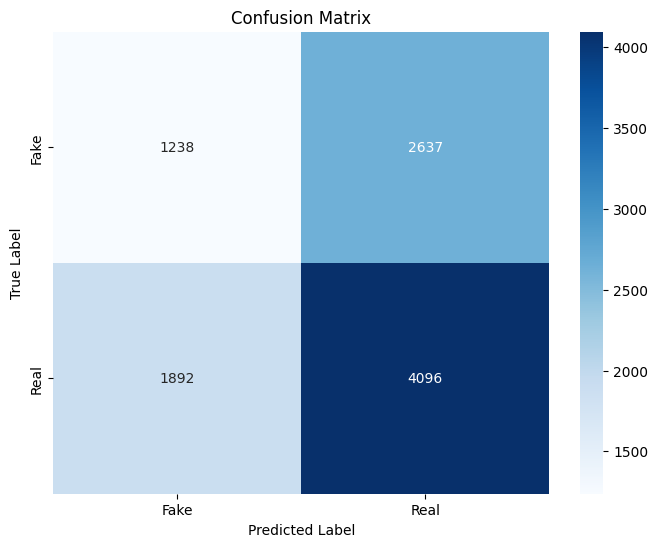


Classification Report:
              precision    recall  f1-score   support

        Fake       0.40      0.32      0.35      3875
        Real       0.61      0.68      0.64      5988

    accuracy                           0.54      9863
   macro avg       0.50      0.50      0.50      9863
weighted avg       0.52      0.54      0.53      9863



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


predictions = largemodel.predict(sample_test)
predicted_classes = np.round(predictions).flatten() 


true_labels = np.concatenate([y.numpy() for _, y in sample_test])


cm = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=['Fake', 'Real']))